In [507]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.formula.api as smf

# regex
import re

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc={'patch.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

&nbsp;

...

&nbsp;

---

# Analyzing Telomere Length Data from TeloFISH
---

## Mean Telomere Length analyses

### Visualizations

In [2]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
all_patients_df['telo data'] = all_patients_df['telo data'].map(literal_eval)

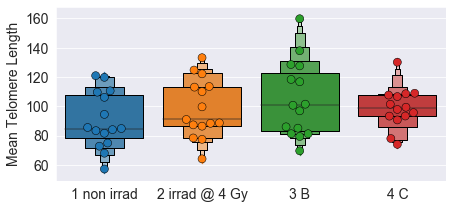

In [81]:
sns.set_style(rc= {'patch.edgecolor': 'black'})

fig = plt.figure(figsize=(7,3.2))
ax = sns.boxenplot(x='timepoint',y='telo means', data=all_patients_df,
                  linewidth=1,)
ax = sns.swarmplot(x='timepoint',y='telo means', data=all_patients_df, size=8,
                  linewidth=.5, edgecolor='black')

# ax.set_title("Mean Telomere Length (TeloFISH) per timepoint") 
ax.set_ylabel('Mean Telomere Length', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.tick_params(labelsize=14)
plt.savefig('../graphs/paper figures/main figs/all patient Mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

### ANOVA, correlations, linear regressions

In [20]:
df = all_patients_df[all_patients_df['patient id'] != 13].copy()

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='telo means',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.05898000440859586


In [21]:
lin_reg_df = all_patients_df.pivot(index='patient id', columns='timepoint', values='telo means')
lin_reg_df = lin_reg_df.drop(13)
lin_reg_df['constant'] = 1

In [22]:
lin_reg_df.corr()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
timepoint,,,,,
1 non irrad,1.000000,0.947341,0.509322,0.401291,NaN
2 irrad @ 4 Gy,0.947341,1.000000,0.620616,0.400194,NaN
3 B,0.509322,0.620616,1.000000,0.534244,NaN
4 C,0.401291,0.400194,0.534244,1.000000,NaN
constant,NaN,NaN,NaN,NaN,NaN


In [23]:
x_names = [['1 non irrad'], ['1 non irrad', '2 irrad @ 4 Gy'],]
#            ['1 non irrad', '2 irrad @ 4 Gy', '3 B']]   
y_name = '4 C'

mtl_df_list = []

for x_name in x_names:
    x = lin_reg_df[x_name].values.reshape(-1, len(x_name))
    y = lin_reg_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
    
    mtl_df_list.append([', '.join(x_name), '4 C', round(regression.score(x, y), 4)])

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.1610
Linear regression for ['1 non irrad', '2 irrad @ 4 Gy'] vs. 4 C:
R2 is 0.1649


In [24]:
mtl_LM_metrics = pd.DataFrame(mtl_df_list, columns=['Model features', 'Target', 'Linear regression R2 score'])
mtl_LM_metrics['Model features'] = mtl_LM_metrics['Model features'].astype('str')

In [25]:
mtl_LM_metrics

,Model features,Target,Linear regression R2 score
0,1 non irrad,4 C,0.1610
1,"1 non irrad, 2 irrad @ 4 Gy",4 C,0.1649


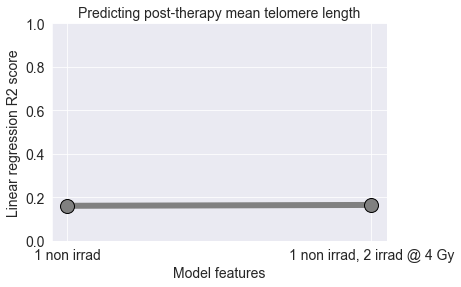

In [26]:
sns.set_style(rc= {'patch.edgecolor': 'black'})
sns.set_color_codes()

fig = plt.figure(figsize=(6,4))
ax = sns.lineplot(x='Model features', y='Linear regression R2 score', data=mtl_LM_metrics, 
                  linewidth=6, sort=False, hue='Target', palette={'4 C':'grey'}, legend=False, marker='o', 
                  **{'markersize':14, 
                     'mec':'black', 
                     'mew':1})
                       
ax.set_ylabel('Linear regression R2 score', fontsize=14)
ax.set_xlabel('Model features', fontsize=14,)

plt.xticks(fontsize=14,)
plt.yticks(fontsize=14)
plt.ylim(0,1)
plt.title('Predicting post-therapy mean telomere length', fontsize=14)

plt.savefig('../graphs/paper figures/main figs/linear regression metrics Mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

In [7]:
# more indepth stats

# target = lin_reg_df['4 C']
# linear_m = sm.OLS(endog=target, exog=lin_reg_df[['1 non irrad', '2 irrad @ 4 Gy', 'constant']], missing='drop')
# results = linear_m.fit()
# results.summary()

## Individual Telomere Length analyses

In [27]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')

### Visualizations

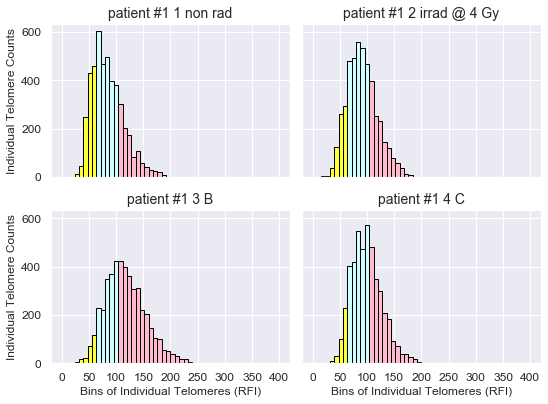

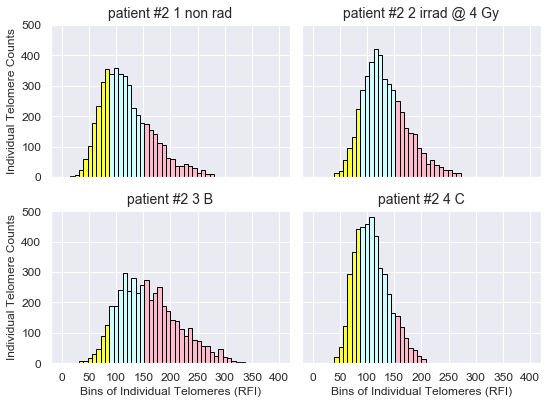

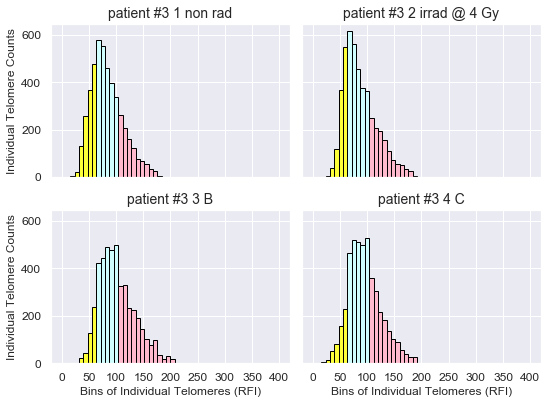

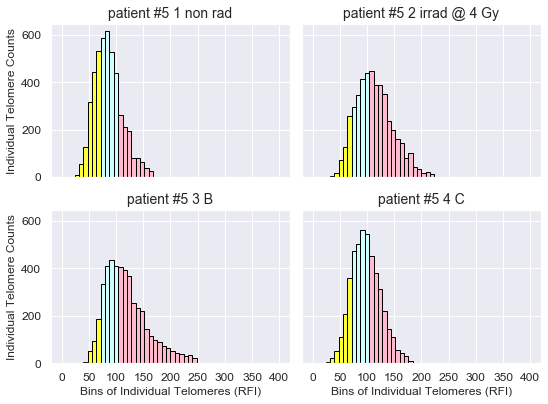

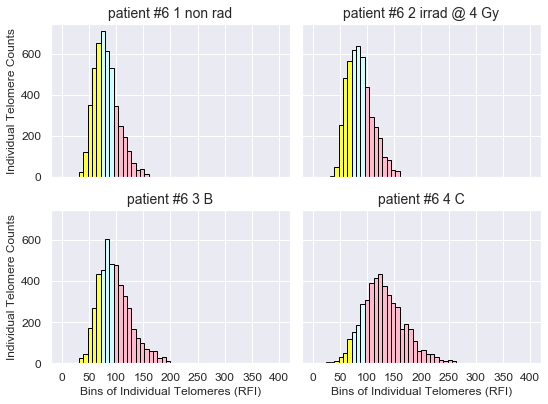

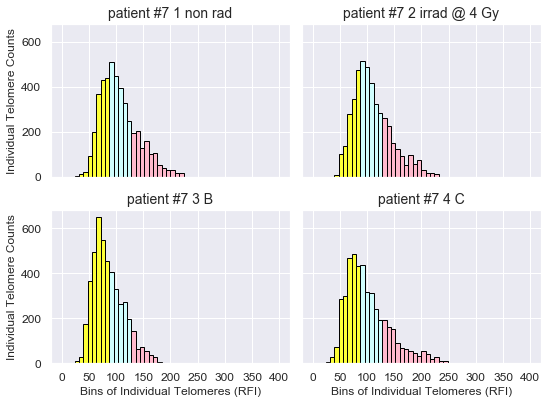

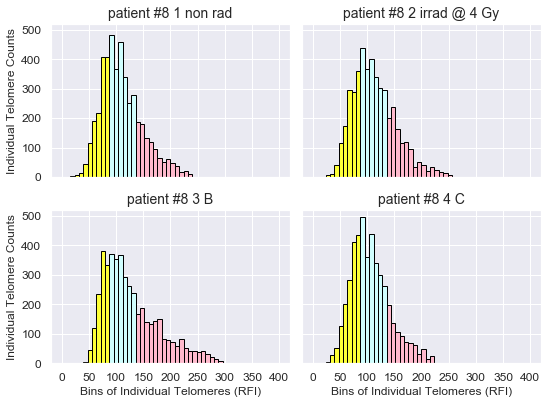

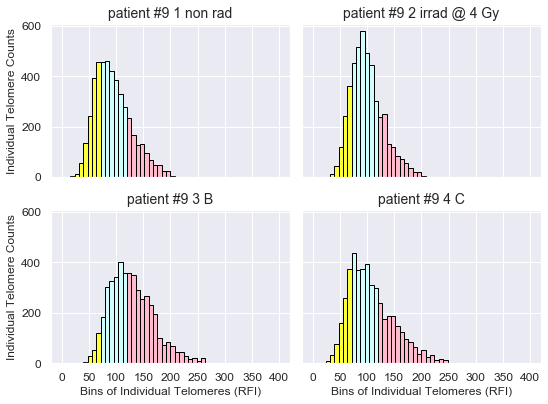

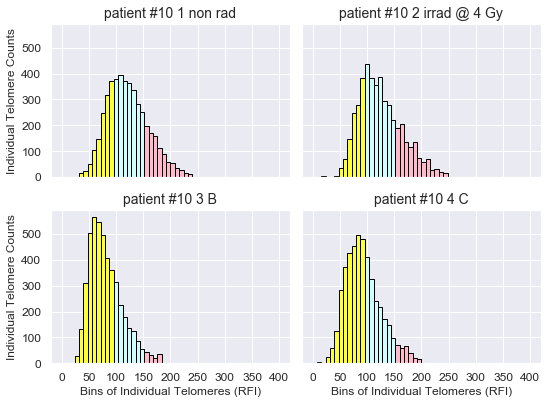

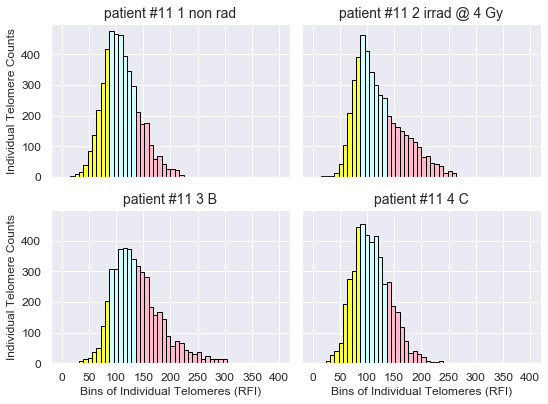

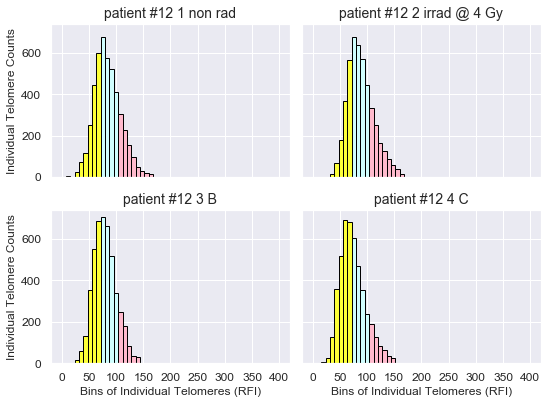

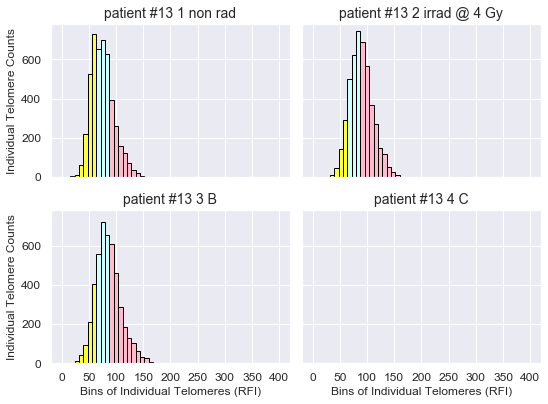

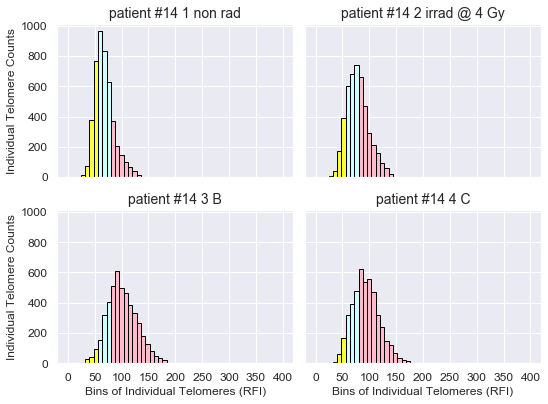

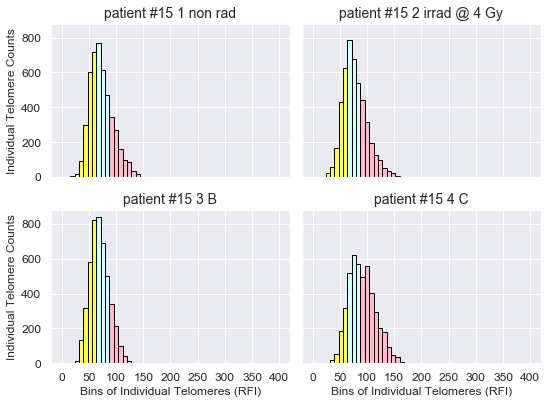

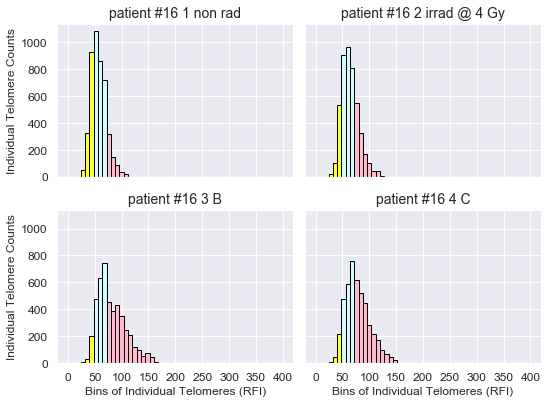

In [707]:
# graphing individual telomeres per individual per timepoint, personal telomere length dynamics as fxn of radiotherapy
patient_ids = list(exploded_telos_all_patients_df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=exploded_telos_all_patients_df.copy(), 
                          groupby='patient id', 
#                           iterable=[patient_ids[1]],
                          iterable=patient_ids,
                          n_bins=50,
                          znorm=False)

### Statistics

#### Linear Mixed Effect Modeling of telomere means

In [75]:
# removing spaces from column names for linear model (doesn't work w/ spaces)
df = exploded_telos_all_patients_df.copy()
df.rename({'individual telomeres': 'individual_telomeres',
           'patient id': 'patient_id'}, axis=1, inplace=True)

# encoding timepoint as numerical, log normalizing individual telos
label_encoder = preprocessing.LabelEncoder()
df['timepoint_encoded'] = label_encoder.fit_transform(df['timepoint'])
df['log_individ_telos'] = np.log(df['individual_telomeres'])

# df = df.groupby(by=['patient_id', 'timepoint']).agg('mean').reset_index()

In [76]:
df = all_patients_df[all_patients_df['patient id'] != 13].copy()

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='telo means',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.05898000440859586


In [413]:
# regressing time onto individual telos w/ random intercepts for patients

model = smf.mixedlm("individual_telomeres ~ timepoint_encoded", 
                    df, 
#                     re_formula='timepoint_encoded',
                    groups=df['patient_id']) 

results = model.fit(method='powell')
results.summary()
results.pvalues[0:4]

Intercept            4.887136e-108
timepoint_encoded     0.000000e+00
Group Var             6.910804e-03
dtype: float64

#### Post-hoc Tukey HSD 

In [414]:
obj = pairwise_tukeyhsd(df['individual_telomeres'], df['timepoint'])
obj.summary()

group1,group2,meandiff,lower,upper,reject
1 non irrad,2 irrad @ 4 Gy,8.297,7.7796,8.8144,True
1 non irrad,3 B,14.4682,13.9509,14.9856,True
1 non irrad,4 C,8.7314,8.2049,9.258,True
2 irrad @ 4 Gy,3 B,6.1713,5.6539,6.6886,True
2 irrad @ 4 Gy,4 C,0.4344,-0.0921,0.961,False
3 B,4 C,-5.7368,-6.2633,-5.2103,True


In [28]:
# test_df = exploded_telos_all_patients_df.copy()
# for col in test_df.columns:
#     test_df.rename({col: col.replace(' ', '_')}, axis=1, inplace=True)
# test_df = test_df[test_df['patient_id'] != 13].copy()

### Graphing all patients overall individual telomere length distributions

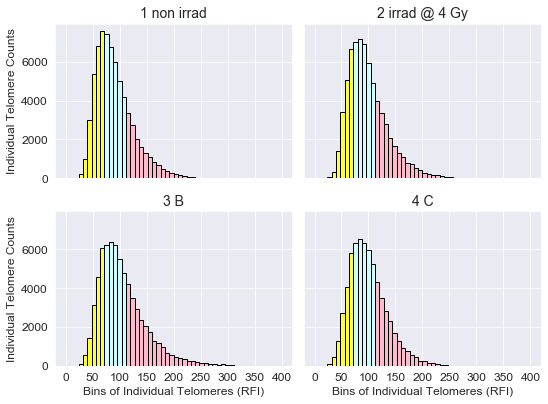

In [113]:
# graphing individual telomeres per timepoint, overall cohort telomere length dynamics as fxn of radiotherapy
df = exploded_telos_all_patients_df.copy()

patient_ids = list(df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=df, 
                          groupby='timepoint', 
                          n_bins=50,
                          znorm=False)

### Graphing cluster 1 patients' individual telomere length distributions

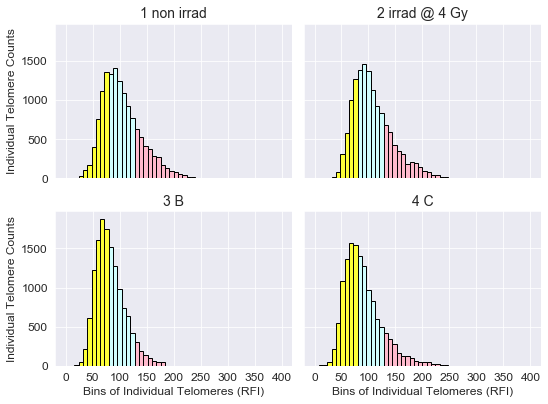

In [108]:
# parsing overall individual telomere dist for cluster 1 
df = exploded_telos_all_patients_df[exploded_telos_all_patients_df['patient id'].isin([7,10,12])].copy()

patient_ids = list(df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=df, 
                          groupby='timepoint', 
                          n_bins=50,
                          znorm=False)

### Graphing cluster 2 patients' individual telomere length distributions

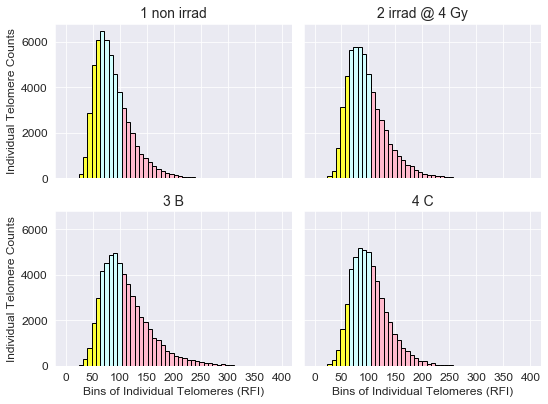

In [109]:
# parsing overall individual telomere dist for cluster 2
df = exploded_telos_all_patients_df[~exploded_telos_all_patients_df['patient id'].isin([7,10,12])].copy()

patient_ids = list(df['patient id'].unique())
trp.histogram_plot_groups(x='individual telomeres', 
                          data=df, 
                          groupby='timepoint', 
                          n_bins=50,
                          znorm=False)

### Kruskal wallis + Z-norm + KS-test w/ bonferroni correction for shape differences between timepoints

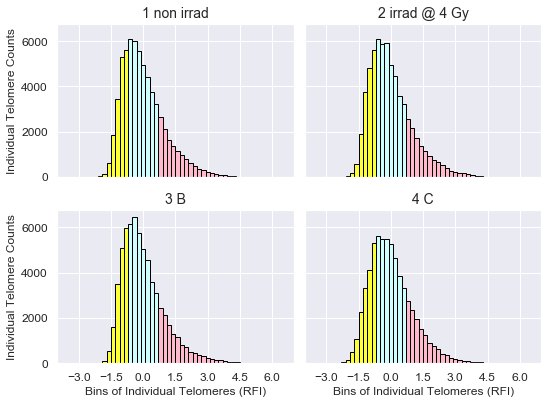

In [478]:
df = exploded_telos_all_patients_df[exploded_telos_all_patients_df['patient id'] != 13].copy()
z_norm = trp.z_norm_individual_telos(exploded_telos_df=df)

# z-norming distributions of individual telomeres per timepoint to enable statistical analysis between
# shapes of overall cohort telomere length dynamics
time_points = list(z_norm['timepoint'].unique())
trp.histogram_plot_groups(x='z-norm_individual_telos', 
                          data=z_norm, 
                          groupby='timepoint', 
                          n_bins=50, 
                          znorm=True)

In [486]:
df = exploded_telos_all_patients_df[exploded_telos_all_patients_df['patient id'] != 13].copy()
target='individual telomeres'

g_1 = df[df['timepoint'] == '1 non irrad'][target]
g_2 = df[df['timepoint'] == '2 irrad @ 4 Gy'][target]
g_3 = df[df['timepoint'] == '3 B'][target]
g_4 = df[df['timepoint'] == '4 C'][target]
statistic, p_value = stats.kruskal(g_1, g_2, g_3, g_4)

print(f'KRUSKAL-WALLIS TEST FOR SIG BETWEEN DISTRIBUTIONS: H STAT: {statistic} P VALUE: {p_value}')

KRUSKAL-WALLIS TEST FOR SIG BETWEEN DISTRIBUTIONS: H STAT: 4417.2500567902225 P VALUE: 0.0


In [479]:
# we see a diff. in shape between all timepoints, as well we see a sig diff between irrad @ 4 Gy & 4 C shapes,
# though mean was the same (ANOVA)

test = ks_2samp
test_name = 'Kolmogorov-Smirnov'
timept_pairs, row = trp.eval_make_test_comparisons(df=z_norm, target='z-norm_individual_telos',
                                                   test=test, test_name=test_name,)

KS_stats_df = pd.DataFrame(row, columns=[test_name, 'timepoint 1', 'timepoint 2', 
                                         'p value', 'KS statistic'])

# iterate for between patients as well? would just be loop using above fxn, passing df per patient

Kolmogorov-Smirnov | 1 non irrad vs 2 irrad @ 4 Gy P-VALUE: 0.07238870179647408 KS-STAT 0.007173913043478253
Kolmogorov-Smirnov | 1 non irrad vs 3 B P-VALUE: 2.3151814439595848e-05 KS-STAT 0.013276397515527949
Kolmogorov-Smirnov | 1 non irrad vs 4 C P-VALUE: 8.402756230273283e-16 KS-STAT 0.023431677018633537
Kolmogorov-Smirnov | 2 irrad @ 4 Gy vs 3 B P-VALUE: 6.233890108982835e-06 KS-STAT 0.014021739130434793
Kolmogorov-Smirnov | 2 irrad @ 4 Gy vs 4 C P-VALUE: 5.758230093941806e-19 KS-STAT 0.025729813664596257
Kolmogorov-Smirnov | 3 B vs 4 C P-VALUE: 1.341631992664129e-27 KS-STAT 0.031149068322981366


In [480]:
# bonferroni pvalue correction to KS-tests
bonferroni_corr = multipletests(KS_stats_df['p value'], method='bonferroni')

# assigning elements of correction to objects
true_false_reject_hyp, pval_corr = bonferroni_corr[0], bonferroni_corr[1]
alpha_c_sidak, alpha_c_bonf = bonferroni_corr[2], bonferroni_corr[3]

# df from vals
bonf_corr_df = pd.DataFrame({'Reject null?': true_false_reject_hyp, 'Bonferroni corrected p values': pval_corr,
                             'Sidak corrected alpha': alpha_c_sidak, 'Bonferroni corrected alpha': alpha_c_bonf})

In [481]:
# merging bonferroni pvals w/ original KS stats & saving to file
KS_stats_df[['Bonferroni corrected p values', 'Reject null?']] = bonf_corr_df[['Bonferroni corrected p values', 
                                                                               'Reject null?']]
display(KS_stats_df)

trp.df_to_png(df=KS_stats_df, 
              path='../graphs/paper figures/supp figs/KS test between overall shapes of individ telo dist.png')

,Kolmogorov-Smirnov,timepoint 1,timepoint 2,p value,KS statistic,Bonferroni corrected p values,Reject null?
0,Kolmogorov-Smirnov,1 non irrad,2 irrad @ 4 Gy,7.238870e-02,0.007174,4.343322e-01,False
1,Kolmogorov-Smirnov,1 non irrad,3 B,2.315181e-05,0.013276,1.389109e-04,True
2,Kolmogorov-Smirnov,1 non irrad,4 C,8.402756e-16,0.023432,5.041654e-15,True
3,Kolmogorov-Smirnov,2 irrad @ 4 Gy,3 B,6.233890e-06,0.014022,3.740334e-05,True
4,Kolmogorov-Smirnov,2 irrad @ 4 Gy,4 C,5.758230e-19,0.025730,3.454938e-18,True
5,Kolmogorov-Smirnov,3 B,4 C,1.341632e-27,0.031149,8.049792e-27,True


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


### Feature Engineering Short/Long Individual Telomeres

In [28]:
melted_all_patients_df = pd.melt(
    all_patients_df,
    id_vars = [col for col in all_patients_df.columns if col != 'Q1' and col != 'Q2-3' and col != 'Q4'],
    var_name='relative Q',
    value_name='Q freq counts')

melted_all_patients_df['Q freq counts'] = melted_all_patients_df['Q freq counts'].astype('float64')

In [29]:
def change_qcol_descrip(row):
    if row == 'Q1':
        return 'short'
    elif row == 'Q2-3':
        return 'medium'
    elif row == 'Q4':
        return 'long'

melted_all_patients_df['relative Q'] = melted_all_patients_df['relative Q'].apply(lambda row: change_qcol_descrip(row))

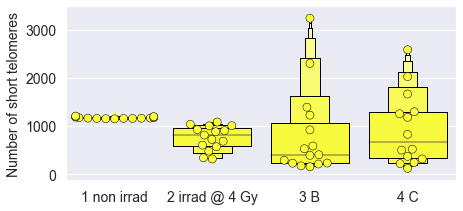

In [221]:
sns.set_style(rc= {'patch.edgecolor': 'black'})
palette ={"Q1":"#fdff38","medium":"#d0fefe","long":"#ffbacd"}

fig = plt.figure(figsize=(7,3.2))
ax = sns.boxenplot(x='timepoint',y='Q1', data=all_patients_df,
                  linewidth=1, color="#fdff38", saturation=.95)
ax = sns.swarmplot(x='timepoint',y='Q1', data=all_patients_df, size=8,
                  linewidth=.5, edgecolor='black', color="#fdff38")

# ax.set_title("Mean Telomere Length (TeloFISH) per timepoint") 
ax.set_ylabel('Number of short telomeres', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.tick_params(labelsize=14)
plt.savefig('../graphs/paper figures/main figs/all patient Number of short telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

In [68]:
stats_df_cts = all_patients_df.copy()
stats_df_cts['Q1_sqrt'] = np.sqrt(stats_df_cts['Q1'])
stats_df_cts['Q4_sqrt'] = np.sqrt(stats_df_cts['Q4'])
stats_df_cts.head()

,patient id,timepoint,telo data,telo means,Q1,Q2-3,Q4,Q1_sqrt,Q4_sqrt
0,1,1 non irrad,"[70.74301669292741, 91.86033510872664, 59.1284...",84.796483,1195,2225,1180,34.568772,34.351128
1,1,2 irrad @ 4 Gy,"[91.86033510872664, 119.31165592077517, 99.251...",90.975826,724,2350,1526,26.907248,39.064050
2,1,3 B,"[191.10982054566642, 141.48603338585482, 114.0...",116.779989,231,1457,2912,15.198684,53.962950
3,1,4 C,"[86.58100550477684, 139.3729078012595, 99.2504...",99.346299,372,2241,1987,19.287302,44.575778
4,2,1 non irrad,"[149.47242207268806, 104.23734697174298, 171.1...",119.773675,1166,2270,1164,34.146742,34.117444


In [69]:
df = stats_df_cts[stats_df_cts['patient id'] != 13].copy()
# df = all_patients_df[all_patients_df['patient id'] != 13].copy()

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='Q1_sqrt',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.041484514376121384
      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
    group1         group2     meandiff  lower    upper  reject
--------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy -6.4897  -16.0887  3.1094 False 
 1 non irrad        3 B        -8.561   -18.16   1.038  False 
 1 non irrad        4 C       -6.0259  -15.6249  3.5731 False 
2 irrad @ 4 Gy      3 B       -2.0713  -11.6704  7.5277 False 
2 irrad @ 4 Gy      4 C        0.4638  -9.1353  10.0628 False 
     3 B            4 C        2.5351  -7.0639  12.1341 False 
--------------------------------------------------------------
pvalues: [0.2877665730794384, 0.0963089267871261, 0.3521526580484169, 0.9, 0.9, 0.8917208985830509]


In [70]:
df = stats_df_cts[stats_df_cts['patient id'] != 13].copy()
# df = all_patients_df[all_patients_df['patient id'] != 13].copy()

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='Q4_sqrt',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.054153500056322156


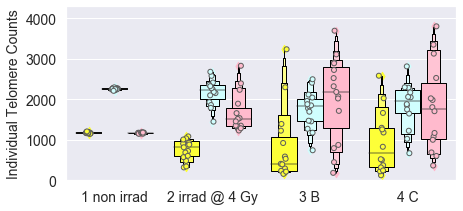

In [142]:
# ax = sns.set(font_scale=1)
fig = plt.figure(figsize=(7,3.2))
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
# palette ={"Q1":"#fdff38","Q2-3":"#d0fefe","Q4":"#ffbacd"}
palette ={"short":"#fdff38","medium":"#d0fefe","long":"#ffbacd"}


ax = sns.boxenplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=2, saturation=5, color="black", )
ax = sns.stripplot(x='timepoint', y='Q freq counts', hue='relative Q', data=melted_all_patients_df, palette=palette,
             linewidth=1, color="black", dodge=True, )

ax=fig.gca()
# ax.set_title('Changes in Distribution Individual Telos Relative to Pre-Rad Therapy Time point', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Individual Telomere Counts', fontsize=14)
ax.tick_params(labelsize=14)

ax.get_legend().remove()
plt.ylim(0,4300)


# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[0:3], labels[0:3], bbox_to_anchor=(.99,0.75), loc="upper left", 
# #            borderaxespad=0)

plt.savefig('../graphs/paper figures/supp figs/counting # short long telos.png', 
            dpi=400,
            bbox_inches='tight')

In [150]:
# nb_regression = all_patients_df.copy()
# nb_regression['constant'] = 1
# label_encoder = preprocessing.LabelEncoder()
# nb_regression['encoded_timepoint'] = label_encoder.fit_transform(nb_regression['timepoint'])

# results = sm.GLM(nb_regression['Q4'], nb_regression[['encoded_timepoint', 'constant']], 
#           family=sm.families.NegativeBinomial()).fit()
# results.summary()

### Linear regression short telo counts

In [71]:
q_lr_df = all_patients_df.pivot(index='patient id', columns='timepoint', values='Q1')
q_lr_df.drop(13, inplace=True)
q_lr_df['constant'] = 1

q_lr_df.head()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
patient id,,,,,
1,1195.0,724.0,231.0,372.0,1
2,1166.0,481.0,292.0,1182.0,1
3,1190.0,1006.0,407.0,503.0,1
5,1159.0,319.0,234.0,521.0,1
6,1188.0,929.0,587.0,124.0,1


In [119]:
# from statsmodels.genmod.generalized_linear_model import GLM

In [134]:
results = sm.GLM(q_lr_df['4 C'], q_lr_df[['1 non irrad', '2 irrad @ 4 Gy', 'constant']], 
          family=sm.families.NegativeBinomial()).fit()

In [135]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    4 C   No. Observations:                   14
Model:                            GLM   Df Residuals:                       11
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -106.83
Date:                Thu, 20 Feb 2020   Deviance:                       3.8896
Time:                        15:40:07   Pearson chi2:                     3.13
No. Iterations:                     6   Covariance Type:             nonrobust
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
1 non irrad       -0.0359      0.016     -2.296      0.022      -0.067      -0.005
2 irrad @ 4 Gy     0.0011      0.001      0.881      0.378      -0.001       0.003
constant          47.9832     18.544      2.587      0.010      11.637      84.330
==================================================================================
"""

In [72]:
x_names = [['1 non irrad'], ['1 non irrad', '2 irrad @ 4 Gy'],] 
y_name = '4 C'

numst_df_list = []

for x_name in x_names:
    name = x_name[0]
    
    x = q_lr_df[x_name].values.reshape(-1, len(x_name))
    y = q_lr_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
    
    numst_df_list.append([', '.join(x_name), '4 C', round(regression.score(x, y), 4)])

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.4328
Linear regression for ['1 non irrad', '2 irrad @ 4 Gy'] vs. 4 C:
R2 is 0.5536


In [73]:
qLM_metrics = pd.DataFrame(numst_df_list, columns=['Model features', 'Target', 'Linear regression R2 score'])
qLM_metrics['Model features'] = qLM_metrics['Model features'].astype('str')
qLM_metrics.head()

,Model features,Target,Linear regression R2 score
0,1 non irrad,4 C,0.4328
1,"1 non irrad, 2 irrad @ 4 Gy",4 C,0.5536


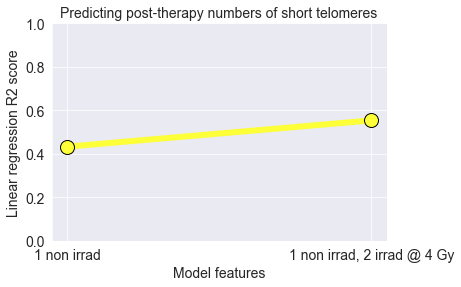

In [74]:
sns.set_style(rc= {'patch.edgecolor': 'black'})
sns.set_color_codes()

fig = plt.figure(figsize=(6,4))
ax = sns.lineplot(x='Model features', y='Linear regression R2 score', data=qLM_metrics, 
                  linewidth=6, sort=False, hue='Target', palette={'4 C':'#fdff38'}, legend=False, marker='o', 
                  **{'markersize':14, 
                     'mec':'black', 
                     'mew':1})

ax.set_ylabel('Linear regression R2 score', fontsize=14)
ax.set_xlabel('Model features', fontsize=14,)
# ax.tick_params(labelsize=14,)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0,1)
plt.title('Predicting post-therapy numbers of short telomeres', fontsize=14)

plt.savefig('../graphs/paper figures/main figs/linear regression metrics numbers short telos teloFISH.png', 
            dpi=400, bbox_inches = "tight")

### Linear regression long telo counts

In [75]:
long_lr_df = all_patients_df.pivot(index='patient id', columns='timepoint', values='Q4')
long_lr_df.drop(13, inplace=True)
long_lr_df['constant'] = 1

long_lr_df.head()

timepoint,1 non irrad,2 irrad @ 4 Gy,3 B,4 C,constant
patient id,,,,,
1,1180.0,1526.0,2912.0,1987.0,1
2,1164.0,1537.0,2527.0,602.0,1
3,1164.0,1350.0,2074.0,1808.0,1
5,1166.0,2831.0,2893.0,2026.0,1
6,1174.0,1515.0,2184.0,3806.0,1


In [76]:
# results = sm.GLM(long_lr_df['4 C'], long_lr_df[['1 non irrad', '2 irrad @ 4 Gy', 'constant']], 
#           family=sm.families.NegativeBinomial()).fit()

# results.summary()

In [77]:
x_names = [['1 non irrad'], ['1 non irrad', '2 irrad @ 4 Gy'],] 
y_name = '4 C'

long_df_list = []

for x_name in x_names:
    name = x_name[0]
    
    x = long_lr_df[x_name].values.reshape(-1, len(x_name))
    y = long_lr_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
    
    long_df_list.append([', '.join(x_name), '4 C', round(regression.score(x, y), 4)])

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.0459
Linear regression for ['1 non irrad', '2 irrad @ 4 Gy'] vs. 4 C:
R2 is 0.2082


In [78]:
long_LM_metrics = pd.DataFrame(long_df_list, columns=['Model features', 'Target', 'Linear regression R2 score'])
long_LM_metrics['Model features'] = long_LM_metrics['Model features'].astype('str')
long_LM_metrics.head()

,Model features,Target,Linear regression R2 score
0,1 non irrad,4 C,0.0459
1,"1 non irrad, 2 irrad @ 4 Gy",4 C,0.2082


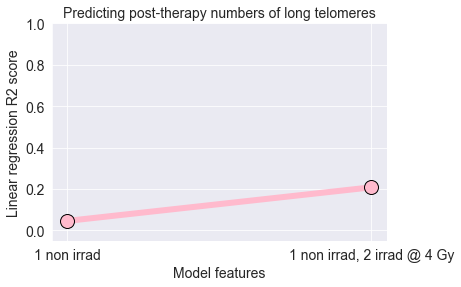

In [79]:
sns.set_style(rc= {'patch.edgecolor': 'black'})
sns.set_color_codes()

fig = plt.figure(figsize=(6,4))
ax = sns.lineplot(x='Model features', y='Linear regression R2 score', data=long_LM_metrics, 
                  linewidth=6, sort=False, hue='Target', palette={'4 C':'#ffbacd'}, legend=False, marker='o', 
                  **{'markersize':14, 
                     'mec':'black', 
                     'mew':1})

ax.set_ylabel('Linear regression R2 score', fontsize=14)
ax.set_xlabel('Model features', fontsize=14,)
# ax.tick_params(labelsize=14,)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-.05,1)
plt.title('Predicting post-therapy numbers of long telomeres', fontsize=14)

plt.savefig('../graphs/paper figures/main figs/linear regression metrics numbers long telos teloFISH.png', 
            dpi=400, bbox_inches = "tight")

# Analyzing Telomere Length Data from qPCR (Aidan/Lynn)
---

In [64]:
all_qPCR_df = pd.read_csv('../data/qPCR telo data/all_qPCR_df.csv')

Text(0.5, 0, 'timepoint')

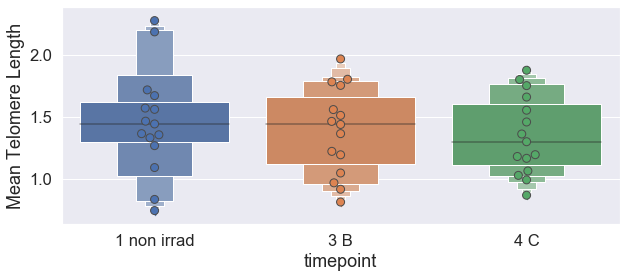

In [121]:
fig = plt.figure(figsize=(10,4))
ax = sns.set(font_scale = 1.5)

ax= sns.boxenplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1)
ax= sns.swarmplot(x='timepoint', y='telo means qPCR', data=all_qPCR_df,
             linewidth=1, size=8)

# ax.set_title("Mean Telomere Length (qPCR) Per Timepoint") 
ax.set_ylabel('Mean Telomere Length')
ax.set_xlabel('timepoint')
# plt.savefig('../graphs/telomere length/all patient telomere length means qPCR.png', dpi=400)

## Correlations and Linear Regressions 

In [70]:
pivot_qPCR_df = all_qPCR_df.pivot(index='patient id', columns='timepoint', values='telo means qPCR')
pivot_qPCR_df['constant'] = 1
pivot_qPCR_df.corr()

timepoint,1 non irrad,3 B,4 C,constant
timepoint,,,,
1 non irrad,1.000000,0.765298,0.769699,NaN
3 B,0.765298,1.000000,0.880080,NaN
4 C,0.769699,0.880080,1.000000,NaN
constant,NaN,NaN,NaN,NaN


In [22]:
x_names = [['1 non irrad'], ['1 non irrad', '3 B']]
y_name = '4 C'

for x_name in x_names:
    x = pivot_qPCR_df[x_name].values.reshape(-1, len(x_name))
    y = pivot_qPCR_df['4 C'].values.reshape(-1, 1)
    regression = LinearRegression().fit(x, y)
    print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")

Linear regression for ['1 non irrad'] vs. 4 C:
R2 is 0.5924
Linear regression for ['1 non irrad', '3 B'] vs. 4 C:
R2 is 0.7969


In [23]:
# more indepth stats
# target = pivot_qPCR_df['4 C']
# linear_m = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', 'constant']], missing='drop')
# results = linear_m.fit()
# print(results.summary())

In [24]:
# linear_m2 = sm.OLS(endog=target, exog=pivot_qPCR_df[['1 non irrad', '3 B', 'constant']], missing='drop')
# results2 = linear_m2.fit()
# print(results2.summary())

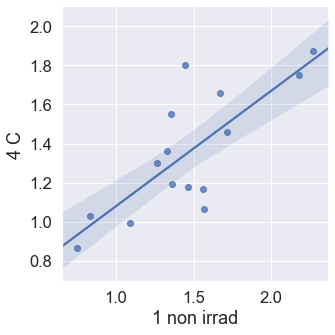

In [25]:
sns.lmplot(x='1 non irrad', y='4 C', data=pivot_qPCR_df, fit_reg=True)

## Statistics 

In [26]:
# conducting one-way ANOVA for mean telomere length
# need change to repeated measures 

df = all_qPCR_df
g_1 = df[df['timepoint'] == '1 non irrad']['telo means qPCR']
g_2 = df[df['timepoint'] == '3 B']['telo means qPCR']
g_3 = df[df['timepoint'] == '4 C']['telo means qPCR']
stats.f_oneway(g_1, g_2, g_3)

F_onewayResult(statistic=0.33940643369655527, pvalue=0.714128148014912)

# Analyzing Chromosome Aberration Data from dGH
---

In [43]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')
general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False, adjust_clonality=True))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

In [44]:
cleaned_chr_df['# inversions'] = cleaned_chr_df['# inversions'] + cleaned_chr_df['# terminal inversions']
cleaned_chr_df.drop(['# terminal inversions'], axis=1, inplace=True)

In [45]:
melt_aberrations = pd.melt(cleaned_chr_df, id_vars=['patient id', 'timepoint'],
                           var_name='aberration type', value_name='count per cell')

melt_aberrations['count per cell'] = melt_aberrations['count per cell'].astype('int64')
melt_aberrations['aberration type'] = melt_aberrations['aberration type'].astype('str')

In [46]:
melt_aberrations['aberration type'].unique()

array(['# inversions', '# sister chromatid exchanges', '# dicentrics',
       '# excess chr fragments', '# sat associations', '# terminal SCEs',
       '# translocations'], dtype=object)

## Visualizing Chromosome Rearrangements

In [29]:
# melt_aberrations_chr_only = melt_aberrations[~melt_aberrations['aberration type'].isin(['# sub-telo SCEs', 'tricentrics',
#                                                                                         '# dicentrics', '# translocations',
#                                                                                         '# sat associations', 'cell number'])].copy()

# ax = sns.set(font_scale=2)
# ax = sns.catplot(y='aberration type', x='count per cell', hue='chromosome', 
#                  col='timepoint', col_wrap=2, 
#                  data=melt_aberrations_chr_only, kind='bar', height=7, aspect=1.5, orient="h",)

# ax.set_ylabels('')
# ax.set_xlabels('average count per cell')

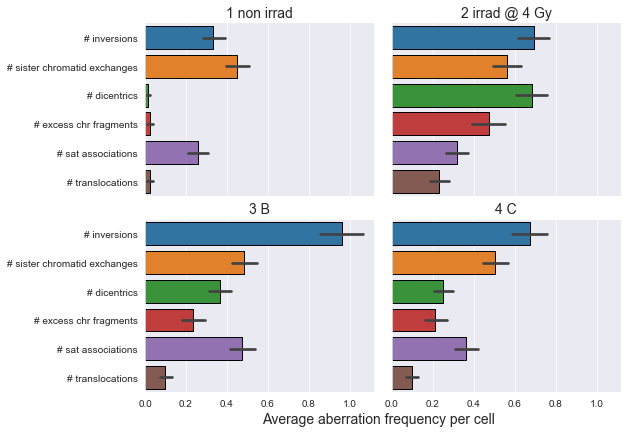

In [13]:
df = melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'].copy()
df.rename({'timepoint':'Time point'}, axis=1, inplace=True)

ax = sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})
# ax = sns.set(font_scale=1.35)
ax = sns.catplot(y='aberration type', x='count per cell',
                 col='Time point', col_wrap=2,  
                 data=df, 
                 kind='bar', height=3., aspect=1.5, orient="h",)

fontsize=14

ax.set_ylabels('', fontsize=fontsize)
ax.set_xlabels('', fontsize=fontsize)
plt.xlabel('Average aberration frequency per cell', horizontalalignment='right', x=0.45,
           fontsize=14)

axes = ax.axes.flatten()
axes[0].set_title("1 non irrad", fontsize=fontsize)
axes[1].set_title("2 irrad @ 4 Gy", fontsize=fontsize)
axes[2].set_title("3 B", fontsize=fontsize)
axes[3].set_title("4 C", fontsize=fontsize)

ax.savefig('../graphs/paper figures/main figs/all patients rearrangements.png', dpi=400,
          bbox_inches = "tight")

In [27]:
aberr = melt_aberrations[melt_aberrations['aberration type'] == '# inversions']
aberr.head()

,patient id,timepoint,aberration type,count per cell
0,1,1 non irrad,# inversions,0
1,1,1 non irrad,# inversions,1
2,1,1 non irrad,# inversions,0
3,1,1 non irrad,# inversions,0
4,1,1 non irrad,# inversions,0


In [31]:
res = pairwise_tukeyhsd(aberr['count per cell'], aberr['timepoint'])
res.summary()

group1,group2,meandiff,lower,upper,reject
1 non irrad,2 irrad @ 4 Gy,0.3595,0.2046,0.5144,True
1 non irrad,3 B,0.6262,0.4713,0.7811,True
1 non irrad,4 C,0.3405,0.1856,0.4954,True
2 irrad @ 4 Gy,3 B,0.2667,0.1117,0.4216,True
2 irrad @ 4 Gy,4 C,-0.019,-0.174,0.1359,False
3 B,4 C,-0.2857,-0.4406,-0.1308,True


In [32]:
from statsmodels.stats.libqsturng import psturng

print(list(psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)))

[0.001, 0.001, 0.001, 0.001, 0.9, 0.001]


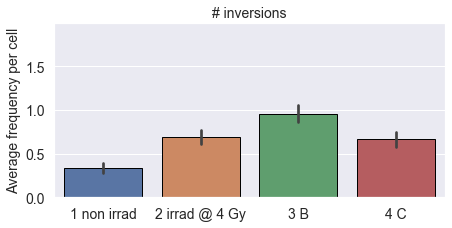

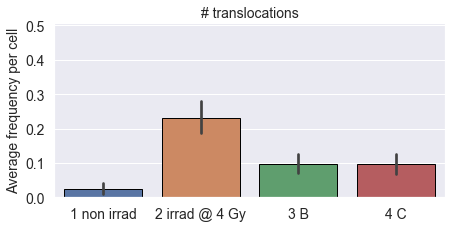

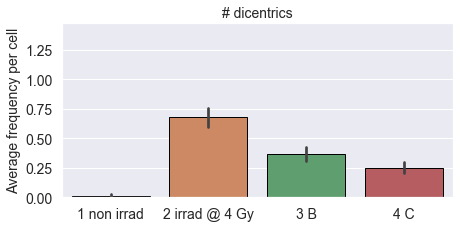

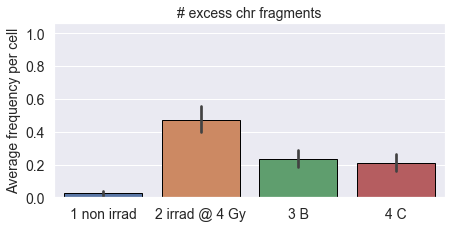

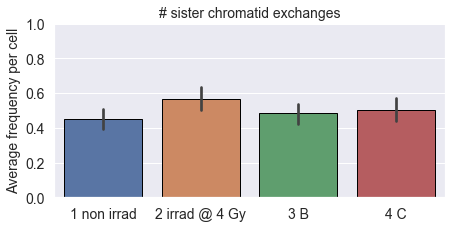

In [62]:
trp.graph_all_aberrations_freq(melt_aberrations=melt_aberrations)

In [61]:
import importlib
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


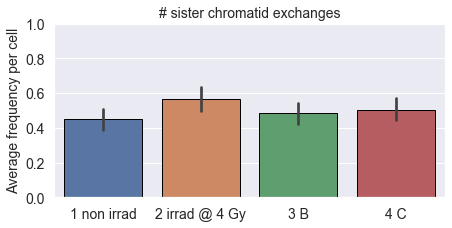

In [60]:
trp.graph_all_aberrations_freq(melt_aberrations=melt_aberrations, aberr_list=['# sister chromatid exchanges'])

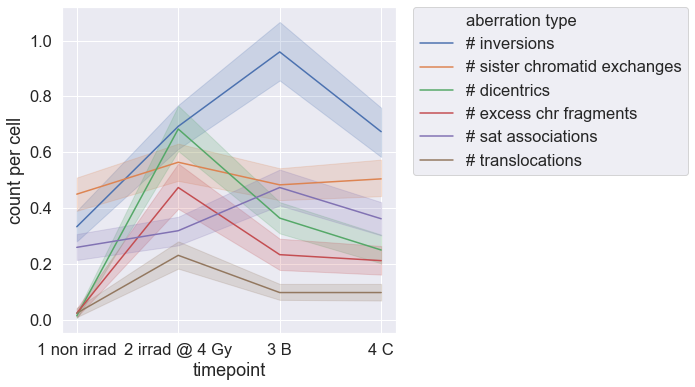

In [33]:
plt.figure(figsize=(6,6))
ax=sns.set(font_scale=1.5)
ax = sns.lineplot(x='timepoint', y='count per cell', data=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'],
                  hue='aberration type', 
#                   palette=sns.color_palette("terrain", melt_aberrations['aberration type'].nunique()),
                  )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## Statistics Chromosome Rearrangements

In [47]:
label_encoder = preprocessing.LabelEncoder()
melt_aberrations['timepoint_encoded'] = label_encoder.fit_transform(melt_aberrations['timepoint'])

In [48]:
trp.chr_scipy_anova_post_hoc_tests(df0=melt_aberrations[melt_aberrations['aberration type'] != '# terminal SCEs'],
                                   post_hoc='tukeyHSD', repeated_measures=True)

# inversions 2.8793128491455715e-15
      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  0.3595   0.2046  0.5144  True 
 1 non irrad        3 B        0.6262   0.4713  0.7811  True 
 1 non irrad        4 C        0.3405   0.1856  0.4954  True 
2 irrad @ 4 Gy      3 B        0.2667   0.1117  0.4216  True 
2 irrad @ 4 Gy      4 C        -0.019   -0.174  0.1359 False 
     3 B            4 C       -0.2857  -0.4406 -0.1308  True 
-------------------------------------------------------------
# inversions pvalues: [0.001, 0.001, 0.001, 0.001, 0.9, 0.001]


# sister chromatid exchanges 0.06700814306980919


# dicentrics 3.774831915280363e-21
      Multiple Comparison of Means - Tukey HSD,FWER=0.05     
    group1         group2     meandiff  lower   upper  reject
-------------------------------------------------------------
 1 non 

In [49]:
cleaned_chr_df['aberration index'] = (cleaned_chr_df['# inversions'] + 
                                      cleaned_chr_df['# translocations'] + cleaned_chr_df['# dicentrics'] + 
                                      cleaned_chr_df['# excess chr fragments'])

In [50]:
# pivoting out aberrations for linear regression

group_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()
# pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values='# inversions')

In [51]:
row = []
aberr_types = [col for col in group_chr.columns if col != 'patient id' and col != 'timepoint']

for aberr in aberr_types:
    pivot_chr = group_chr.pivot(index='patient id', columns='timepoint', values=aberr)
    x_name2 = ['1 non irrad']
    x_name3 = ['1 non irrad', '2 irrad @ 4 Gy']
    y_name = '4 C'

#     print(f'ABERRATION TYPE | {aberr}')
    for x_name in [x_name2, x_name3]:
        x = pivot_chr[x_name].values.reshape(-1, len(x_name))
        y = pivot_chr['4 C'].values.reshape(-1, 1)

        regression = LinearRegression().fit(x, y)
#         print(f"Linear regression for {x_name} vs. {y_name}:\nR2 is {regression.score(x, y):.4f}")
#         print('\n')
        row.append(['Linear Regression', aberr, x_name, y_name, f'{regression.score(x, y):.4f}'])
    
LM_aberr_r2 = pd.DataFrame(data=row, columns=['Model', 'Aberration type', 'Features', 'Target', 'Linear regression R2 score'])

In [52]:
LM_aberr_r2['Features'] = LM_aberr_r2['Features'].apply(lambda row: ', '.join(row))
LM_aberr_r2['Linear regression R2 score'] = LM_aberr_r2['Linear regression R2 score'].astype('float64')

In [53]:
chr_interest = ['# inversions', 
                '# translocations', '# dicentrics', '# excess chr fragments',
                'aberration index']

chr_df = LM_aberr_r2[LM_aberr_r2['Aberration type'].isin(chr_interest)]

In [54]:
chr_df.reset_index(inplace=True, drop=True)

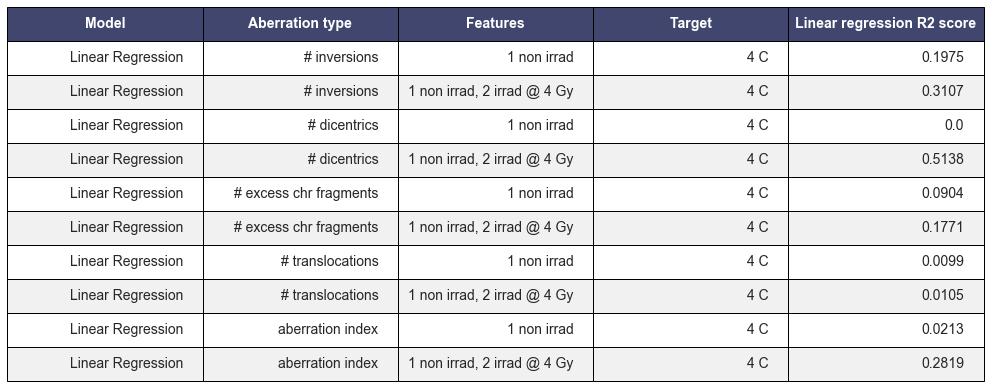

In [64]:
path=f'../graphs/paper figures/supp figs/linear regression chr aberr models.png'
trp.render_mpl_table(chr_df, col_width=3.5, path=path)

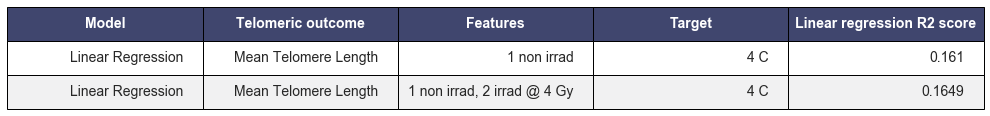

In [65]:
mtl_LM_metrics = pd.DataFrame(mtl_df_list, columns=['Features', 'Target', 'Linear regression R2 score'])
mtl_LM_metrics['Features'] = mtl_LM_metrics['Features'].astype('str')
mtl_LM_metrics['Model'] = 'Linear Regression'
mtl_LM_metrics['Telomeric outcome'] = 'Mean Telomere Length'
mtl_ordered = mtl_LM_metrics[['Model', 'Telomeric outcome', 'Features', 'Target', 'Linear regression R2 score']]

path=f'../graphs/paper figures/supp figs/linear regression mean telomere length models.png'
trp.render_mpl_table(mtl_ordered, col_width=3.5, path=path)

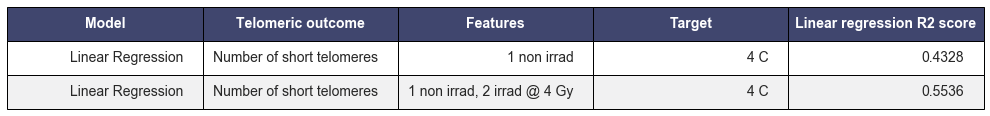

In [66]:
qLM_LM_metrics = pd.DataFrame(numst_df_list, columns=['Features', 'Target', 'Linear regression R2 score'])
qLM_LM_metrics['Features'] = qLM_LM_metrics['Features'].astype('str')
qLM_LM_metrics['Model'] = 'Linear Regression'
qLM_LM_metrics['Telomeric outcome'] = 'Number of short telomeres'
qLM_ordered = qLM_LM_metrics[['Model', 'Telomeric outcome', 'Features', 'Target', 'Linear regression R2 score']]

path=f'../graphs/paper figures/supp figs/linear regression number of short telomeres models.png'
trp.render_mpl_table(qLM_ordered, col_width=3.5, path=path)

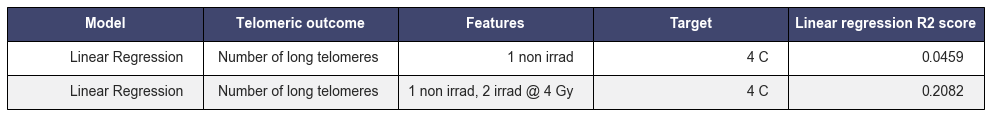

In [67]:
long_LM_metrics = pd.DataFrame(long_df_list, columns=['Features', 'Target', 'Linear regression R2 score'])
long_LM_metrics['Features'] = long_LM_metrics['Features'].astype('str')
long_LM_metrics['Model'] = 'Linear Regression'
long_LM_metrics['Telomeric outcome'] = 'Number of long telomeres'
long_ordered = long_LM_metrics[['Model', 'Telomeric outcome', 'Features', 'Target', 'Linear regression R2 score']]

path=f'../graphs/paper figures/supp figs/linear regression number of long telomeres models.png'
trp.render_mpl_table(long_ordered, col_width=3.5, path=path)

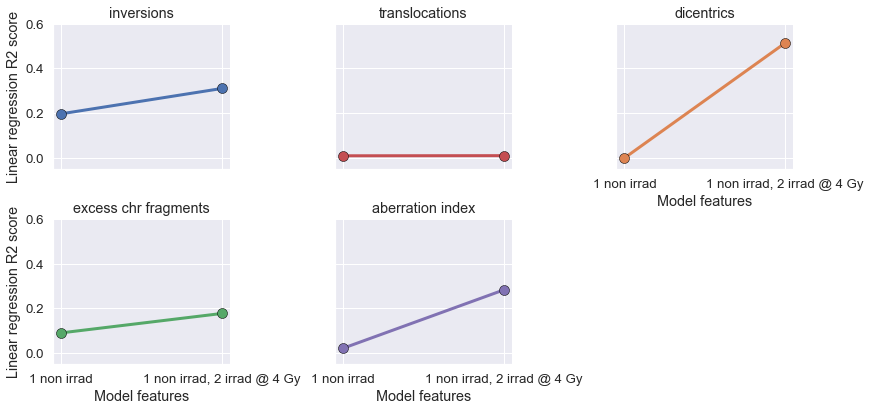

In [42]:
ax = sns.set(font_scale=1.2)
col_order=['# inversions', '# translocations', '# dicentrics', '# excess chr fragments', 'aberration index']
ax = sns.relplot(x='Features', y='Linear regression R2 score', data=chr_df, 
                 col='Aberration type', hue='Aberration type', kind='line', col_order=col_order, 
                 col_wrap=3, legend=False, height=2.9, aspect=1.40, 
                 facet_kws={'sharey':True, 'sharex':True},
                 **{'linewidth':3, 'marker':'o', 'markersize':10,
                    'mec':'black', 'mew':0.5, })

ax.set_xlabels('Model features')

# ax.set_xticklabels(ha='center')
# ax[0].set_title('# inversions')
ax_list = ax.axes
ax_list[0].set_title('inversions')
ax_list[1].set_title('translocations')
ax_list[2].set_title('dicentrics')
ax_list[3].set_title('excess chr fragments')
ax_list[4].set_title('aberration index')

plt.ylim(-0.05,0.6)

plt.tight_layout(pad=.7)
plt.savefig(f'../graphs/paper figures/supp figs/linear regression performance for all chr aberr types.png',
           dpi=400, bbox_inches='tight')

# Analyzing Complete Blood Count Data

## Loading TeloFISH, chromosome aberration, CBC data

In [325]:
# loading TeloFISH data

all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
all_patients_df['telo data'] = all_patients_df['telo data'].map(literal_eval)
all_patients_df.drop(['telo data', 'Q1', 'Q2-3', 'Q4'], axis=1, inplace=True)

In [326]:
# loading chromosome aberration data

all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False, adjust_clonality=True))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
cleaned_chr_df['# inversions'] = cleaned_chr_df['# inversions'] + cleaned_chr_df['# terminal inversions']
cleaned_chr_df.drop(['# terminal inversions'], axis=1, inplace=True)

grp_chr_aberr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

In [327]:
# loading qPCR telo data

all_qPCR_df = pd.read_csv('../data/qPCR telo data/all_qPCR_df.csv')

In [328]:
# loading cbc counts data

cbc_data = pd.read_csv('../data/compiled patient data csv files/cleaned cbc data.csv')
cbc_data.drop(['date', 'on AA 0=no 1=yes', 'LN 0=n 1=y', '  dose   0=78  1=70   2= implant 3=70/28 4=1800/3 bst'], 
              axis=1, inplace=True)

In [347]:
# merging teloFISH + CBC, qPCR + CBC, chr aberrations + CBC, & merging all

merge_telofish_cbc = all_patients_df.merge(cbc_data, on=['patient id', 'timepoint'])

merge_qpcr = all_qPCR_df.merge(cbc_data, on=['patient id', 'timepoint'])

merge_chr_cbc = grp_chr_aberr.merge(cbc_data, on=['patient id', 'timepoint'])

merge_all = merge_telofish_cbc.merge(grp_chr_aberr, on=['patient id', 'timepoint'])

## TeloFISH vs. CBC data

In [561]:
merge_telofish_cbc.corr()

,patient id,telo means,WBC,RBC,Hgb,Hct,mcv,mch,mchc,rdw,...,cd3 abs,cd4%,cd4 abs,cd 8%,cd 8 abs,cd 19%,cd 19 abs,cd4/cd8,NK %,NK abs
patient id,1.000000,-0.482406,0.045076,0.056003,0.216487,0.086520,0.151196,0.270799,0.347655,-0.220234,...,0.047696,-0.345496,-0.060331,0.377962,0.201079,0.113894,0.093738,-0.419719,-0.240242,-0.141554
telo means,-0.482406,1.000000,-0.126405,-0.063405,-0.048631,0.009699,0.117051,0.054275,-0.145268,-0.007756,...,-0.265807,0.281594,-0.190007,-0.250713,-0.331702,-0.288298,-0.304504,0.429559,0.408281,0.118537
WBC,0.045076,-0.126405,1.000000,0.001271,0.220666,0.227359,0.271600,0.260500,0.054146,-0.372158,...,0.539096,0.306203,0.639397,-0.225986,0.340598,0.170815,0.437403,0.267823,-0.185876,0.289421
RBC,0.056003,-0.063405,0.001271,1.000000,0.330533,0.325687,-0.551065,-0.448978,0.063059,0.378307,...,0.407696,-0.037649,0.386152,0.158299,0.333421,-0.075314,0.126309,-0.060543,-0.103375,0.323583
Hgb,0.216487,-0.048631,0.220666,0.330533,1.000000,0.921122,0.374157,0.494990,0.439348,-0.352577,...,0.361162,0.053451,0.324169,0.382794,0.368324,-0.038466,0.089672,-0.257840,-0.265620,0.210809
Hct,0.086520,0.009699,0.227359,0.325687,0.921122,1.000000,0.383547,0.350255,0.056114,-0.230922,...,0.369794,0.032424,0.346737,0.253293,0.343606,0.072362,0.176192,-0.152870,-0.256686,0.213496
mcv,0.151196,0.117051,0.271600,-0.551065,0.374157,0.383547,1.000000,0.918503,0.106445,-0.582201,...,-0.118412,0.056052,-0.117447,0.046161,-0.052865,0.130086,0.044068,-0.050749,-0.095841,-0.169225
mch,0.270799,0.054275,0.260500,-0.448978,0.494990,0.350255,0.918503,1.000000,0.489273,-0.661689,...,-0.078138,0.083939,-0.091850,0.193523,0.008687,0.001873,-0.034821,-0.155774,-0.118079,-0.130829
mchc,0.347655,-0.145268,0.054146,0.063059,0.439348,0.056114,0.106445,0.489273,1.000000,-0.394782,...,0.066935,0.089432,0.028703,0.397382,0.143590,-0.265709,-0.178768,-0.299353,-0.106153,0.023885
rdw,-0.220234,-0.007756,-0.372158,0.378307,-0.352577,-0.230922,-0.582201,-0.661689,-0.394782,1.000000,...,-0.078095,-0.075194,-0.119642,0.022586,-0.052700,-0.114159,-0.089429,-0.001233,-0.051859,-0.198498


### Longitudinal correlations between mean telomere length & CBC data

In [564]:
# parsing high correlation data

df = merge_telofish_cbc.copy()

hi_r_variables = []

for col in df.columns:
    if col != 'patient id' and col != 'telo means' and col != 'timepoint':
        r2_value = df[['telo means', col]].corr().iloc[0][1]
        if abs(r2_value) > 0:
            hi_r_variables.append([col, r2_value])
#             print(col, r2_value)

In [652]:
r2_telos_corr = pd.DataFrame(hi_r_variables, columns=['marker', 'R2 correlation'])
r2_telos_celltype = r2_telos_corr[r2_telos_corr['marker'].isin(['lymph#', 'mono#', 'gran#', 'eos#', 'baso#'])].copy()
r2_telos_lymph_percent = r2_telos_corr[r2_telos_corr['marker'].isin(['NK %', 'cd4%', 'cd 8%', 'cd 19%'])].copy()

In [653]:
r2_telos_celltype.head()

,marker,R2 correlation
15,gran#,0.016935
16,lymph#,-0.293638
17,mono#,-0.094394
18,eos#,0.023208
19,baso#,0.278747


In [659]:
m_r2_telos_celltype = r2_telos_celltype.copy()

m_r2_telos_celltype['marker'].iloc[0] = 'granulocyes'
m_r2_telos_celltype['marker'].iloc[1] = 'lymphocytes'
m_r2_telos_celltype['marker'].iloc[2] = 'monocytes'
m_r2_telos_celltype['marker'].iloc[3] = 'eosinophils'
m_r2_telos_celltype['marker'].iloc[4] = 'basophils'

In [677]:
plt.xticks

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

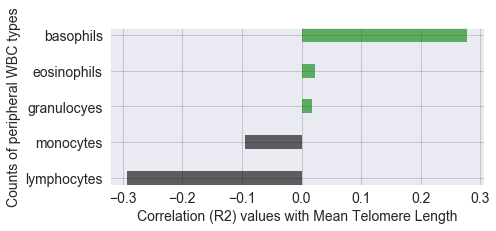

In [696]:
df = m_r2_telos_celltype.copy()
x = df['R2 correlation']
df['colors'] = ['black' if x < 0 else 'green' for x in df['R2 correlation']]
df.sort_values('R2 correlation', inplace=True)
df.reset_index(inplace=True, drop=True)

plt.figure(figsize=(7,3.2))
plt.hlines(y=df.index, xmin=0, xmax=df['R2 correlation'], color=df['colors'], alpha=0.6, linewidth=14,)

# Decorations
plt.yticks(df.index, df['marker'], fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Correlation (R2) values with Mean Telomere Length', fontsize=14)
plt.ylabel('Counts of peripheral WBC types', fontsize=14)

plt.grid(linestyle='-', alpha=.2, color='black')
plt.tight_layout()

plt.savefig('../graphs/paper figures/supp figs/correlations between WBC cell type counts and telomere length.png', dpi=400,
            bbox_inches='tight')

In [640]:
m_r2_telos_lymph_percent = r2_telos_lymph_percent.copy()

m_r2_telos_lymph_percent['marker'].iloc[0] = 'CD4 %'
m_r2_telos_lymph_percent['marker'].iloc[1] = 'CD8 %'
m_r2_telos_lymph_percent['marker'].iloc[2] = 'CD19 %'
m_r2_telos_lymph_percent['marker'].iloc[3] = 'NK %'

In [702]:
m_r2_telos_lymph_percent

,marker,R2 correlation,colors
0,CD19 %,-0.288298,black
1,CD8 %,-0.250713,black
2,CD4 %,0.281594,green
3,NK %,0.408281,green


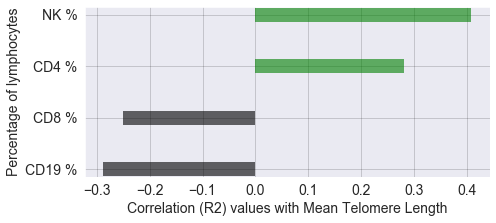

In [671]:
df = m_r2_telos_lymph_percent
x = df['R2 correlation']
df['colors'] = ['black' if x < 0 else 'green' for x in df['R2 correlation']]
df.sort_values('R2 correlation', inplace=True)
df.reset_index(inplace=True, drop=True)

plt.figure(figsize=(7,3.2))
plt.hlines(y=df.index, xmin=0, xmax=df['R2 correlation'], color=df['colors'], alpha=0.6, linewidth=14,)

# Decorations
plt.yticks(df.index, df['marker'], fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Correlation (R2) values with Mean Telomere Length', fontsize=14)
plt.ylabel('Percentage of lymphocytes', fontsize=14)

plt.grid(linestyle='-', alpha=.2, color='black')
plt.tight_layout()

plt.savefig('../graphs/paper figures/supp figs/correlations between proportions of lymphocytes and telomere length.png', 
            dpi=400,
            bbox_inches='tight')

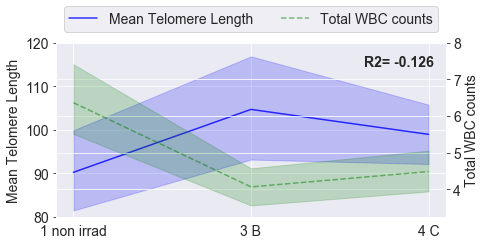

In [701]:
trp.graph_cyto_cbc_data(plot_cyto_y='telo means', plot_cbc_y='WBC', df=merge_telofish_cbc,
                        cyto_name='Mean Telomere Length', cbc_name='Total WBC counts',
                        ylim1=(80, 120),
                        ylim2=(3.25, 8))

## Chromosome aberrations vs. CBC data

In [704]:
# merge_chr_cbc.corr()

In [705]:
merge_chr_cbc.head()

,patient id,timepoint,# inversions,# sister chromatid exchanges,# dicentrics,# excess chr fragments,# sat associations,# terminal SCEs,# translocations,WBC,...,cd3 abs,cd4%,cd4 abs,cd 8%,cd 8 abs,cd 19%,cd 19 abs,cd4/cd8,NK %,NK abs
0,1,1 non irrad,0.233333,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333,8.7,...,1740,50,1175,23,541,17,400,2.17,7,158
1,1,3 B,1.266667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000,5.7,...,528,64,404,19,119,4,27,3.40,9,57
2,1,4 C,0.566667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333,5.9,...,431,50,294,21,124,11,64,2.38,14,83
3,2,1 non irrad,0.300000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333,5.3,...,740,42,472,25,275,15,170,1.72,15,171
4,2,3 B,1.066667,0.700000,0.300000,0.166667,0.466667,1.000000,0.033333,5.6,...,203,53,147,22,61,2,6,2.43,24,67


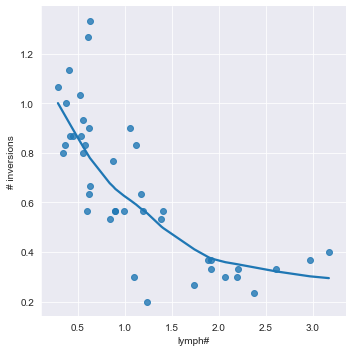

In [707]:
sns.lmplot(x='lymph#', y='# inversions', lowess=True, data=merge_chr_cbc)

### Longitudinal correlations between chromosome aberrations & CBC data

In [149]:
chr_corr_df = pd.DataFrame()

for aberr in grp_chr_aberr.columns:
    if aberr != 'patient id' and aberr != 'timepoint':
        test = grp_chr_aberr[['patient id', 'timepoint', aberr]].merge(cbc_data, on=['patient id', 'timepoint']) 

        df = test.copy()

        hi_r_variables = []

        for col in df:
            if col == 'lymph#':
                r2_value = df[[aberr, col]].corr().iloc[0][1]
                if abs(r2_value) > 0.60:
                    hi_r_variables.append([col, r2_value])
                    print(aberr, col, r2_value)
                    
#         single_aberr_df = pd.DataFrame(hi_r_variables, columns=['CBC data', f'R2 correlation {aberr}'])
    

# inversions lymph# -0.7522869776095474
# dicentrics lymph# -0.7509787076100194
# excess chr fragments lymph# -0.6717065000901444
# translocations lymph# -0.6015085894070261


In [127]:
cbc_corr_telo = pd.DataFrame(hi_r_variables, columns=['CBC data', 'R2 correlation'])
cbc_corr_telo.sort_values(by='R2 correlation', ascending=False).reset_index(drop=True)

,CBC data,R2 correlation
0,cd4/cd8,0.429559
1,NK %,0.408281
2,baso%,0.301144
3,cd4%,0.281594
4,baso#,0.278747
5,cd 8%,-0.250713
6,cd3 abs,-0.265807
7,Abs lym,-0.265932
8,cd 19%,-0.288298
9,lymph#,-0.293638


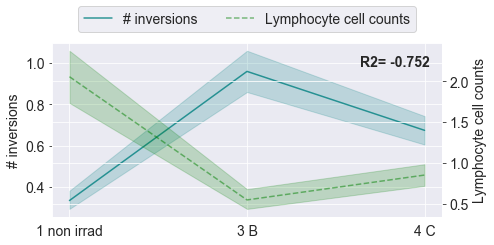

In [333]:
graph_cyto_cbc_data(plot_cyto_y='# inversions', plot_cbc_y='lymph#', df=merge_chr_cbc,
                    cyto_name='# inversions', cbc_name='Lymphocyte cell counts',
                    ax_color1='teal'
                    )

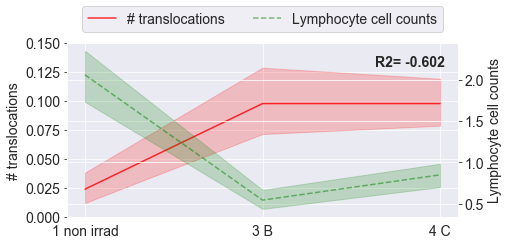

In [322]:
graph_cyto_cbc_data(plot_cyto_y='# translocations', plot_cbc_y='lymph#', df=merge_chr_cbc,
                    cyto_name='# translocations', cbc_name='Lymphocyte cell counts',
                    ax_color1='red',
                    ylim1=(0, 0.15)
                   )

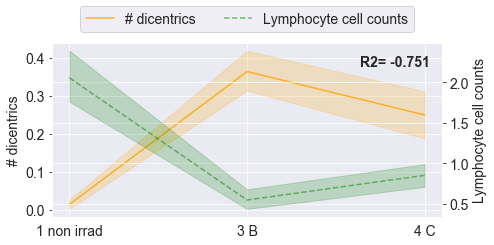

In [323]:
graph_cyto_cbc_data(plot_cyto_y='# dicentrics', plot_cbc_y='lymph#', df=merge_chr_cbc,
                    cyto_name='# dicentrics', cbc_name='Lymphocyte cell counts',
                    ax_color1='orange'
                    )

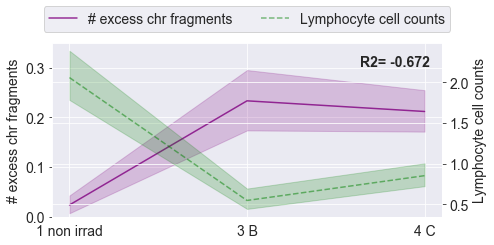

In [324]:
graph_cyto_cbc_data(plot_cyto_y='# excess chr fragments', plot_cbc_y='lymph#', df=merge_chr_cbc,
                    cyto_name='# excess chr fragments', cbc_name='Lymphocyte cell counts',
                    ax_color1='purple',
                    ylim1=(0, 0.35)
                    )

In [127]:
cbc_corr_telo = pd.DataFrame(hi_r_variables, columns=['CBC data', 'R2 correlation'])
cbc_corr_telo.sort_values(by='R2 correlation', ascending=False).reset_index(drop=True)

,CBC data,R2 correlation
0,cd4/cd8,0.429559
1,NK %,0.408281
2,baso%,0.301144
3,cd4%,0.281594
4,baso#,0.278747
5,cd 8%,-0.250713
6,cd3 abs,-0.265807
7,Abs lym,-0.265932
8,cd 19%,-0.288298
9,lymph#,-0.293638


In [149]:
chr_corr_df = pd.DataFrame()

for aberr in grp_chr_aberr.columns:
    if aberr != 'patient id' and aberr != 'timepoint':
        test = grp_chr_aberr[['patient id', 'timepoint', aberr]].merge(cbc_data, on=['patient id', 'timepoint']) 

        df = test.copy()

        hi_r_variables = []

        for col in df:
            if col == 'lymph#':
                r2_value = df[[aberr, col]].corr().iloc[0][1]
                if abs(r2_value) > 0.60:
                    hi_r_variables.append([col, r2_value])
                    print(aberr, col, r2_value)
                    
#         single_aberr_df = pd.DataFrame(hi_r_variables, columns=['CBC data', f'R2 correlation {aberr}'])
    

# inversions lymph# -0.7522869776095474
# dicentrics lymph# -0.7509787076100194
# excess chr fragments lymph# -0.6717065000901444
# translocations lymph# -0.6015085894070261


### Addressing whether recovery fraction of lymphocytes (pre vs. post) correlates with chromosome aberrations

In [361]:
# parsing out time / lymph#
time_cbc = merge_chr_cbc[['patient id', 'timepoint', 'lymph#']]
recovery_percent = time_cbc.pivot_table(index=['patient id'], values='lymph#', columns='timepoint').reset_index()

In [487]:
# feature engineering lymph# percent recovery
recovery_percent['pre vs. post recov %'] = (recovery_percent['4 C'] / recovery_percent['1 non irrad']) * 100
recovery_percent['pre vs. immed post %'] = (recovery_percent['3 B'] / recovery_percent['1 non irrad']) * 100

[Text(0, 0, '0.0%'),
 Text(0, 0, '10.0%'),
 Text(0, 0, '20.0%'),
 Text(0, 0, '30.0%'),
 Text(0, 0, '40.0%'),
 Text(0, 0, '50.0%'),
 Text(0, 0, '60.0%')]

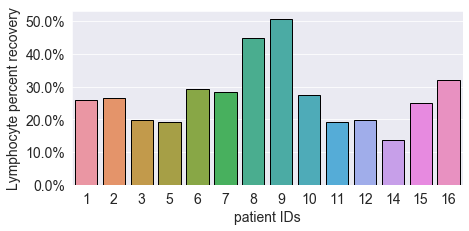

In [488]:
plt.figure(figsize=(7,3.2))

fontsize=14

ax = sns.barplot(x='patient id', y='pre vs. immed post %', data=recovery_percent)

ax.set_ylabel('Lymphocyte percent recovery', fontsize=fontsize)  
ax.set_xlabel('patient IDs', fontsize=fontsize)

# enforcing tick sizes
ax.tick_params(labelsize=14)

labels = ax.get_yticks().tolist()
labels_percent = []
for l in labels:
    labels_percent.append(str(l) + '%')
ax.set_yticklabels(labels_percent)

# plt.savefig('../graphs/paper figures/supp figs/lymphocyte percent recovery.png', dpi=400,
#            bbox_inches = "tight")

In [489]:
# merging lymphocyte percent recovery w/ chr aberr & cbc dataframe

merge_recov_percent_chr = merge_chr_cbc.merge(recovery_percent[['patient id', 
                                                                'pre vs. post recov %',
                                                                'pre vs. immed post %']],
                                                                on=['patient id'])

merge_recov_percent_chr = merge_recov_percent_chr[merge_recov_percent_chr['timepoint'] == '4 C'].copy()

In [495]:
# calculating R2 correlation values between aberrations of interest & pre/post lymphocyte recovery

metric = 'pre vs. post recov %'

aberrations = ['# inversions', '# dicentrics', '# translocations', '# excess chr fragments']
r2_list = []

for aberr in aberrations:
    r2_value = merge_recov_percent_chr[[aberr, metric]].corr()[metric][0]
    r2_list.append([aberr, round(r2_value, 3)])

r2_df = pd.DataFrame(r2_list, columns=['Aberration', 'R2 value'])

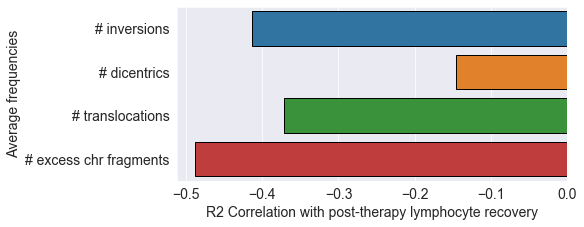

In [496]:
plt.figure(figsize=(7,3.2))

fontsize=14

ax = sns.barplot(y='Aberration', x='R2 value', data=r2_df, orient='h')

ax.set_ylabel('Average frequencies', fontsize=fontsize)  
ax.set_xlabel('R2 Correlation with post-therapy lymphocyte recovery', fontsize=fontsize)
# plt.xticks(rotation=30)

# enforcing tick sizes
ax.tick_params(labelsize=14)

# plt.savefig('../graphs/paper figures/supp figs/correlation aberrations lymphocyte percent recovery.png', dpi=400,
#            bbox_inches='tight')

In [497]:
merge_chr_cbc.head()

,patient id,timepoint,# inversions,# sister chromatid exchanges,# dicentrics,# excess chr fragments,# sat associations,# terminal SCEs,# translocations,WBC,...,cd3 abs,cd4%,cd4 abs,cd 8%,cd 8 abs,cd 19%,cd 19 abs,cd4/cd8,NK %,NK abs
0,1,1 non irrad,0.233333,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333,8.7,...,1740,50,1175,23,541,17,400,2.17,7,158
1,1,3 B,1.266667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000,5.7,...,528,64,404,19,119,4,27,3.40,9,57
2,1,4 C,0.566667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333,5.9,...,431,50,294,21,124,11,64,2.38,14,83
3,2,1 non irrad,0.300000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333,5.3,...,740,42,472,25,275,15,170,1.72,15,171
4,2,3 B,1.066667,0.700000,0.300000,0.166667,0.466667,1.000000,0.033333,5.6,...,203,53,147,22,61,2,6,2.43,24,67
